In [1]:
import os
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import numpy as np
from functools import reduce
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import glob
from pathlib import PurePath
from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import Dataset
import re
import torch.nn.functional as F


In [2]:
import torch
import pytorch_lightning as pl
#from common.nn_modeling.dataset.enumeration import CountingDotsDataSet
from torch.utils.data import DataLoader
import numpy as np
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import pandas as pd
import os, psutil
process = psutil.Process(os.getpid())
from humanfriendly import format_size
import argparse
from functools import reduce
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchvision import transforms
import glob
from pathlib import PurePath
from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import Dataset
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

In [ ]:
class Flatten(nn.Module):

    """
    Helper module for flattening input tensor to 1-D for the use in Linear modules
    """

    def forward(self, x):
        return x.view(x.size(0), -1)


class Identity(nn.Module):

    """
    Helper module that stores the current tensor. Useful for accessing by name
    """

    def forward(self, x):
        return x

In [3]:
# Define the basic block
class CORblock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(CORblock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define the Net architecture
class CORnet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(CORnet, self).__init__()
        self.in_planes = 64
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(1)


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #outputs = {'inp': inp}
        #states = {}
        #blocks = ['inp', 'V1', 'V2', 'V4', 'IT']
        batch_size = x.size(0)
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)#V1
        out = self.layer2(out)#V2
        out = self.layer3(out)#V3
        out = self.layer4(out)#IPS LAYER
        out = self.adaptive_avg_pool(out)#decode part
        avg_pool=out
        out = out.view(batch_size, -1)  
        out = self.linear(out)
        return out,avg_pool

# Define CORnet
def CORnetmodel():
    return CORnet(CORblock, [1,1,1,1])

In [4]:
model_path = 'resnet18_4and8_modelareastimu_grey.pth'

model = CORnetmodel()
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda")
model.to(device)
model.eval()  # Ensure the model is in evaluation mode after loading

print("Model loaded successfully from:", model_path)

C:\Users\10263\AppData\Local\Temp\ipykernel_13600\4273119432.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded successfully from: resnet18_4and8_modelareastimu_grey.pth


In [5]:
device = torch.device("cuda")
model.to(device)
transform=None
model.eval()

CORnet(
  (adaptive_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): CORblock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): CORblock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [6]:
import glob
from pathlib import PurePath
from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import Dataset
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader, ConcatDataset
class MyData(Dataset):

    def __init__(self, root_dir,label_dir, transform):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.image_path = os.path.join(self.root_dir, self.label_dir)
        self.image_list = os.listdir(self.image_path)
        self.transform = transform

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_item_path = os.path.join(self.root_dir, self.label_dir, img_name)
        img = Image.open(img_item_path)
        img = self.transform(img)
        label = self.label_dir
        return img,int(label)

    def __len__(self):
        a=len(self.image_list)
        
        b=int(a)
        return b

In [7]:
transform=None
model.eval()

CORnet(
  (adaptive_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): CORblock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): CORblock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [8]:
class CustomNumpyDataset(Dataset):
    def __init__(self, filename, transform=None):
        self.data  =  np.load(filename)
        self.transform = transform


    def __len__(self):
        archive_data1 = self.data
        return len(archive_data1['Q'])

    def __getitem__(self, idx):

        # Load data from the NumPy zip archive
        archive_data1 = self.data

        # Assuming you have saved the data with keys 'S' and 'Q'
        data_s = archive_data1['S'][idx]
        label = archive_data1['Q'][idx]
        
        tensor_data_s = torch.from_numpy(data_s)
        

        # Combine the data into a single tensor if needed
        # combined_data = torch.cat([tensor_data_s, tensor_data_q], dim=your_concatenation_dim)

        # Return a tuple containing the data and its label
        return tensor_data_s, label

In [9]:
custom_dataset = CustomNumpyDataset(filename=f'./rad5_80/datafilenewrad2.npz', transform=transform)

In [10]:
custom_dataset = CustomNumpyDataset(filename=f'./datafilenewradius10f1.npz', transform=transform)

FileNotFoundError: [Errno 2] No such file or directory: './datafilenewradius10f1.npz'

In [11]:
#images, labels = custom_dataset[13]
#images=images.float()


In [12]:
#images.shape

In [13]:
len(custom_dataset)

300

In [14]:
custom_dataset = CustomNumpyDataset(filename=f'./rad5_80/datafilenewrad2.npz', transform=transform)

In [16]:
tra1 = transforms.Compose([
    transforms.ToTensor(),
    #normalize,          
])

In [11]:
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}')

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [12]:
backward_hook = model.layer4[-1].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = model.layer4[-1].register_forward_hook(forward_hook, prepend=False)

In [13]:
#backward_hook = model.layer4[0].conv2.register_full_backward_hook(backward_hook, prepend=False)
#forward_hook = model.layer4[0].conv2.register_forward_hook(forward_hook, prepend=False)

In [14]:
model.eval()
model.to(device)
a2=a2.to(device)
a2=a2.float()


NameError: name 'a2' is not defined

In [17]:
for i in range(1,7):
    custom_dataset = CustomNumpyDataset(filename=f'./rad5_80/datafilenewrad{2*i}.npz', transform=transform)
    
    with torch.no_grad():
            images= custom_dataset[20][0].unsqueeze(0).to(device)
            
            images=images.float()
            images/= 255
            mask = (images<0.98)
            images[mask]=0.2

            outputs,_ = model(images)
            outputstens=outputs.cpu()

    tensor_path = f'./result_rad5_80/cam/diff1_4_rad10/radiufor{i}.npz'
    np.savez(tensor_path, tensor=outputstens)

Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])


Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])


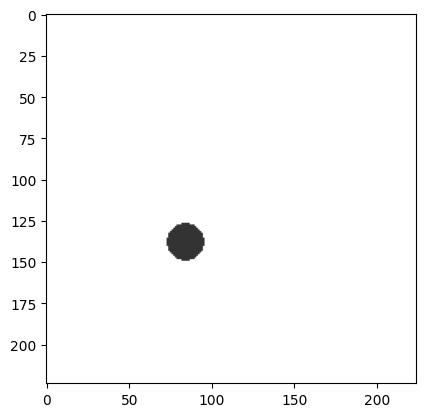

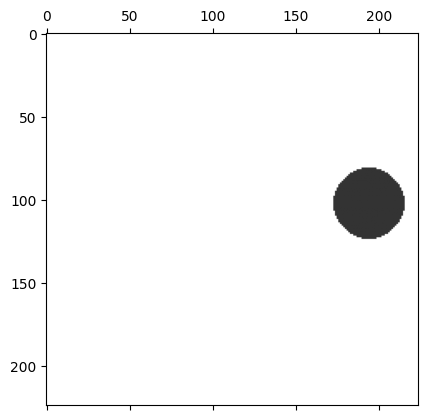

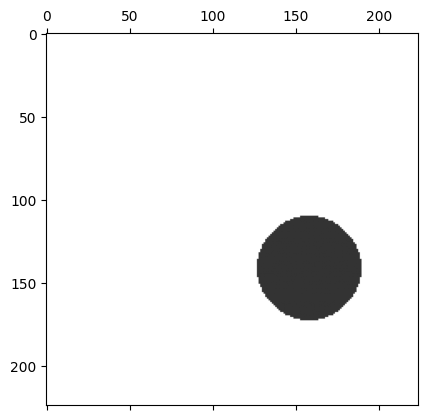

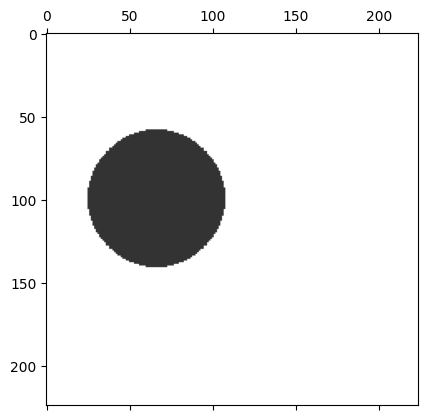

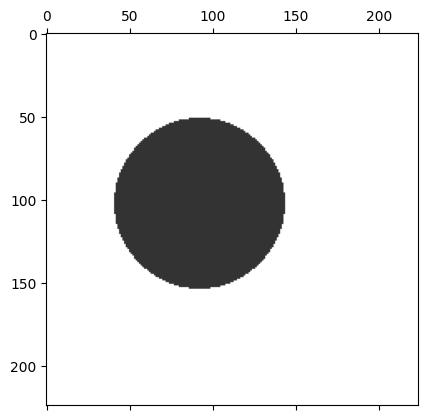

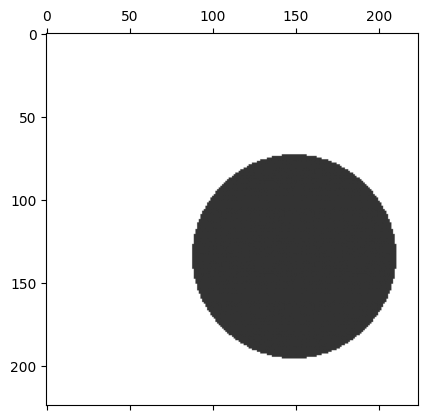

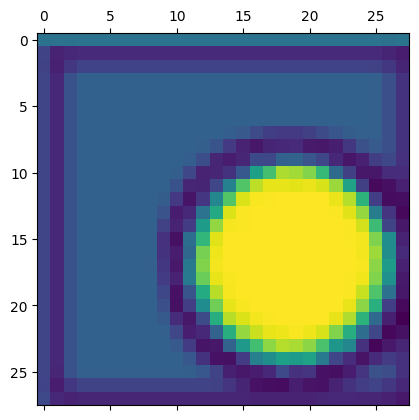

In [18]:
for uu in range(1,7):
    custom_dataset = CustomNumpyDataset(filename=f'./rad5_80/datafilenewrad{2*uu}.npz', transform=transform)

    X=custom_dataset[20][0]
    X1=X.cpu().detach().permute(1, 2, 0).numpy()
    #X1=X1.float()
    X1=np.array(X1, dtype=np.float64)
    X1/=255
    mask = (X1<0.98)
    X1[mask]=0.2

    #X1=X1*0.8
    plt.imshow(X1)
    plt.savefig(f'./camresult/cam/diff1_4_rad10/origin{10*uu}.png')  # Save as PNG file
    a2=X.unsqueeze(0).to(device)
    a2=a2.float()
    a2/= 255
    mask = (a2<0.98)
    a2[mask]=0.2



    #argmax
    scores,pool = model(a2)
    pred=scores.argmax(dim=1)
    loss=scores[0,pred[0]]
    pool=pool.flatten()

    model.zero_grad()
    loss.backward()

    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    # weight the channels by corresponding gradients
    cloned_activations=activations.clone()
    detached_activations = cloned_activations.detach()
    mask = pooled_gradients < 0
    pooled_gradients[mask]=0
    for i in range(detached_activations.size()[1]):
        detached_activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(detached_activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach().cpu())

    plt.savefig(f'./camresult/cam/diff1_4_rad10/myplotmax{10*uu}.png')  # Save as PNG file
    numpy_array = heatmap.cpu().numpy()

    # Save the NumPy array
    np.save(f'./camresult/cam/diff1_4_rad10/heatmapmax{10*uu}.npy', numpy_array)




    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    # weight the channels by corresponding gradients
    cloned_activations=activations.clone()
    detached_activations = cloned_activations.detach()
    mask = pooled_gradients < 0
    pooled_gradients[mask]=0
    sorted_tensor, indices = torch.sort(pooled_gradients, descending=True)
    top_3_elements = sorted_tensor[0:2]
    top_3_indices = indices[0:2]
    zerolike_tensor = torch.ones(1,512,28,28)
    zerolike_tensor=zerolike_tensor.to(device)
    empty_tensor = torch.zeros(28, 28) 
    for i in range(len(top_3_indices)):
        zerolike_tensor[:, top_3_indices[i], :, :]*= detached_activations[:, top_3_indices[i], :, :] * pooled_gradients[top_3_indices[i]]

    # average the channels of the activations
    heatmap = torch.mean(zerolike_tensor, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    #plt.matshow(heatmap.detach().cpu())
    #plt.savefig(f'./camresult/cam/diff1_4_rad10/myplottop2max{10*uu}.png')  # Save as PNG file



    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    # weight the channels by corresponding gradients
    cloned_activations=activations.clone()
    detached_activations = cloned_activations.detach()
    mask = pooled_gradients < 0
    pooled_gradients[mask]=0
    sorted_tensor, indices = torch.sort(pooled_gradients, descending=True)
    top_3_elements = sorted_tensor[0:5]
    top_3_indices = indices[0:5]
    zerolike_tensor = torch.ones(1,512,28,28)
    zerolike_tensor=zerolike_tensor.to(device)
    empty_tensor = torch.zeros(28, 28) 
    for i in range(len(top_3_indices)):
        zerolike_tensor[:, top_3_indices[i], :, :]*= detached_activations[:, top_3_indices[i], :, :] * pooled_gradients[top_3_indices[i]]

    # average the channels of the activations
    heatmap = torch.mean(zerolike_tensor, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    #plt.matshow(heatmap.detach().cpu())
    #plt.savefig(f'./camresult/cam/diff1_4_rad10/myplottop5max{10*uu}.png')  # Save as PNG file

Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])


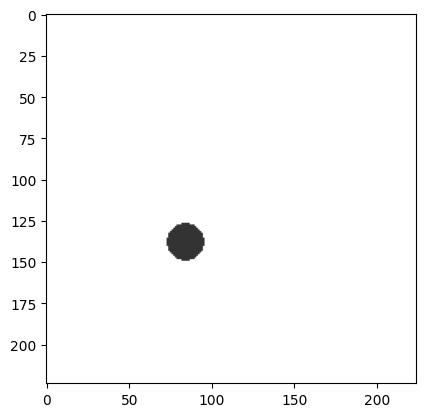

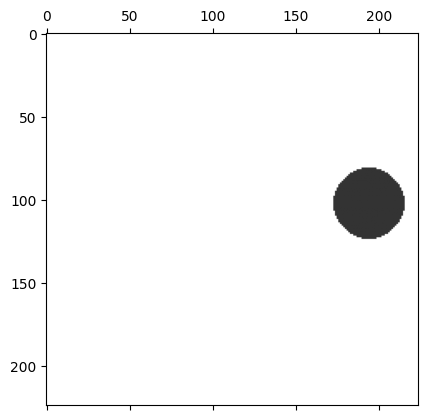

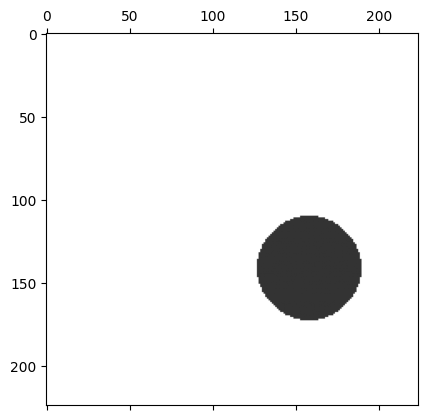

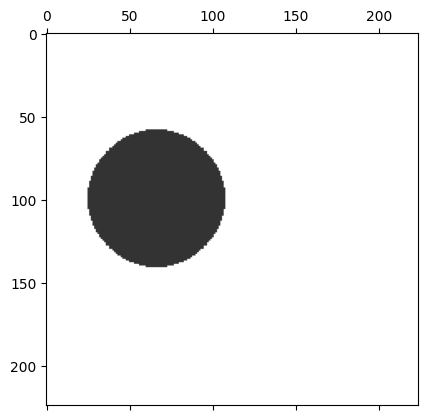

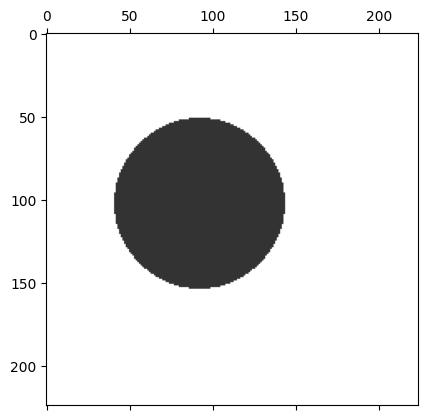

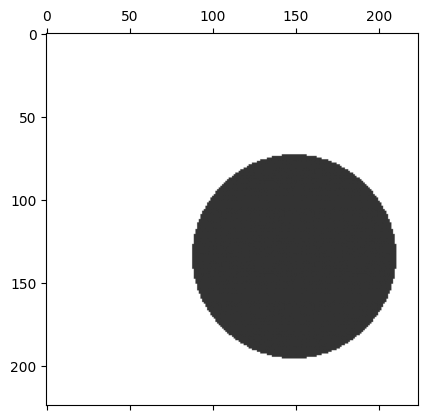

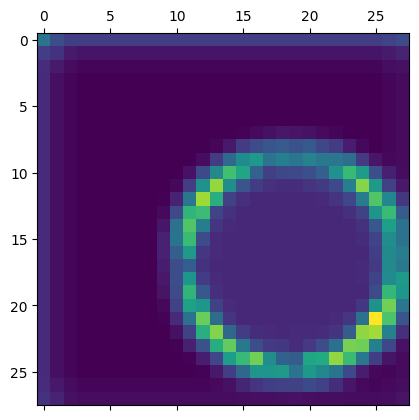

In [19]:
for uu in range(1,7):
    custom_dataset = CustomNumpyDataset(filename=f'./rad5_80/datafilenewrad{2*uu}.npz', transform=transform)

    X=custom_dataset[20][0]
    X1=X.cpu().detach().permute(1, 2, 0).numpy()
    #X1=X1.float()
    X1=np.array(X1, dtype=np.float64)
    X1/=255
    mask = (X1<0.98)
    X1[mask]=0.2

    #X1=X1*0.8
    plt.imshow(X1)
    plt.savefig(f'./camresult/cam/diff1_4_rad10/origin{10*uu}.png')  # Save as PNG file
    a2=X.unsqueeze(0).to(device)
    a2=a2.float()
    a2/= 255
    mask = (a2<0.98)
    a2[mask]=0.2



    #argmin
    scores,pool = model(a2)
    pred=scores.argmin(dim=1)
    loss=scores[0,pred[0]]
    pool=pool.flatten()

    model.zero_grad()
    loss.backward()

    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    # weight the channels by corresponding gradients
    cloned_activations=activations.clone()
    detached_activations = cloned_activations.detach()
    mask = pooled_gradients < 0
    pooled_gradients[mask]=0
    for i in range(detached_activations.size()[1]):
        detached_activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(detached_activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach().cpu())

    plt.savefig(f'./camresult/cam/diff1_4_rad10/myplotmin{10*uu}.png')  # Save as PNG file
    numpy_array = heatmap.cpu().numpy()

    # Save the NumPy array
    np.save(f'./camresult/cam/diff1_4_rad10/heatmapmin{10*uu}.npy', numpy_array)




    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    # weight the channels by corresponding gradients
    cloned_activations=activations.clone()
    detached_activations = cloned_activations.detach()
    mask = pooled_gradients < 0
    pooled_gradients[mask]=0
    sorted_tensor, indices = torch.sort(pooled_gradients, descending=True)
    top_3_elements = sorted_tensor[0:2]
    top_3_indices = indices[0:2]
    zerolike_tensor = torch.ones(1,512,28,28)
    zerolike_tensor=zerolike_tensor.to(device)
    empty_tensor = torch.zeros(28, 28) 
    for i in range(len(top_3_indices)):
        zerolike_tensor[:, top_3_indices[i], :, :]*= detached_activations[:, top_3_indices[i], :, :] * pooled_gradients[top_3_indices[i]]

    # average the channels of the activations
    heatmap = torch.mean(zerolike_tensor, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    #plt.matshow(heatmap.detach().cpu())
    #plt.savefig(f'./camresult/cam/diff1_4_rad10/myplottop2min{10*uu}.png')  # Save as PNG file



    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    # weight the channels by corresponding gradients
    cloned_activations=activations.clone()
    detached_activations = cloned_activations.detach()
    mask = pooled_gradients < 0
    pooled_gradients[mask]=0
    sorted_tensor, indices = torch.sort(pooled_gradients, descending=True)
    top_3_elements = sorted_tensor[0:5]
    top_3_indices = indices[0:5]
    zerolike_tensor = torch.ones(1,512,28,28)
    zerolike_tensor=zerolike_tensor.to(device)
    empty_tensor = torch.zeros(28, 28) 
    for i in range(len(top_3_indices)):
        zerolike_tensor[:, top_3_indices[i], :, :]*= detached_activations[:, top_3_indices[i], :, :] * pooled_gradients[top_3_indices[i]]

    # average the channels of the activations
    heatmap = torch.mean(zerolike_tensor, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    #plt.matshow(heatmap.detach().cpu())
    #plt.savefig(f'./camresult/cam/diff1_4_rad10/myplottop5min{10*uu}.png')  # Save as PNG file

Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
torch.Size([512])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
torch.Size([512])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
torch.Size([512])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
torch.Size([512])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
torch.Size([512])


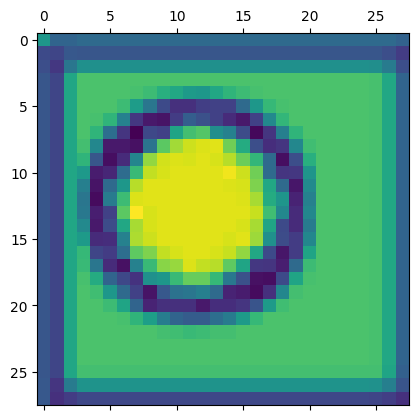

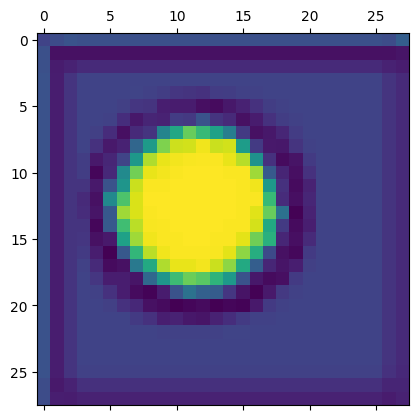

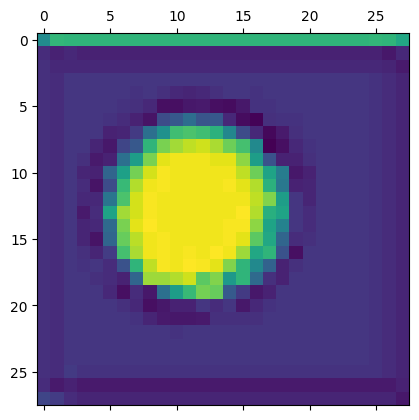

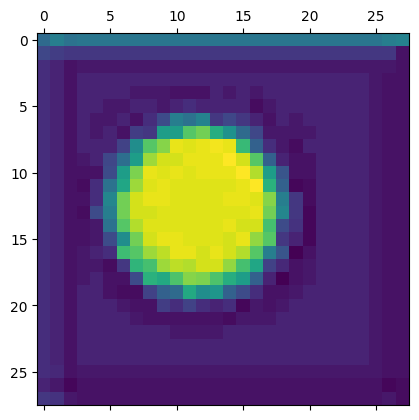

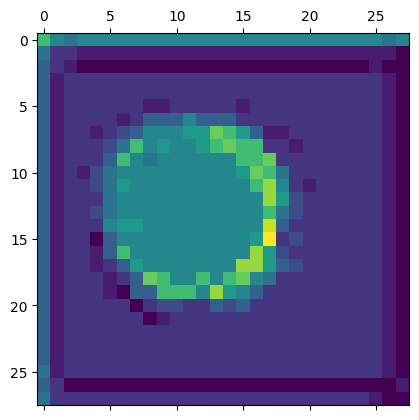

In [20]:
custom_dataset = CustomNumpyDataset(filename=f'./rad5_80/datafilenewrad{10}.npz', transform=transform)

for uu in range(0,5):
    

    X=custom_dataset[20][0]
    X1=X.cpu().detach().permute(1, 2, 0).numpy()
    #X1=X1.float()
    X1=np.array(X1, dtype=np.float64)
    X1/=255
    mask = (X1<0.98)
    X1[mask]=0.2

    #X1=X1*0.8
    #plt.imshow(X1)
    #plt.savefig(f'./camresult/cam/const1_4_rad10/origin{10*uu}.png')  # Save as PNG file
    a2=X.unsqueeze(0).to(device)
    a2=a2.float()
    a2/= 255
    mask = (a2<0.98)
    a2[mask]=0.2



    #argmax
    scores,pool = model(a2)
    pred=scores.argmax(dim=1)
    loss=scores[0,pred[0]]
    pool=pool.flatten()

    model.zero_grad()
    loss.backward()






    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    # weight the channels by corresponding gradients
    cloned_activations=activations.clone()
    detached_activations = cloned_activations.detach()
    mask = pooled_gradients < 0
    pooled_gradients[mask]=0
    sorted_tensor, indices = torch.sort(pooled_gradients, descending=True)
    print(sorted_tensor.size())
    top_3_elements = sorted_tensor[uu*50:uu*50+50]
    top_3_indices = indices[uu*50:uu*50+50]
    zerolike_tensor = torch.ones(1,512,28,28)
    zerolike_tensor=zerolike_tensor.to(device)
    empty_tensor = torch.zeros(28, 28) 
    for i in range(len(top_3_indices)):
        zerolike_tensor[:, top_3_indices[i], :, :]*= detached_activations[:, top_3_indices[i], :, :] * pooled_gradients[top_3_indices[i]]

    # average the channels of the activations
    heatmap = torch.mean(zerolike_tensor, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach().cpu())
    plt.savefig(f'./camresult/cam/diff1_4_rad10/myplottop{50*uu}max.png')  # Save as PNG file


In [ ]:
custom_dataset = CustomNumpyDataset(filename=f'./rad5_80/datafilenewrad{10}.npz', transform=transform)


X=custom_dataset[20][0]
X1=X.cpu().detach().permute(1, 2, 0).numpy()
#X1=X1.float()
X1=np.array(X1, dtype=np.float64)
X1/=255
mask = (X1<0.98)
X1[mask]=0.2

#X1=X1*0.8
#plt.imshow(X1)
#plt.savefig(f'./camresult/cam/const1_4_rad10/origin{10*uu}.png')  # Save as PNG file
a2=X.unsqueeze(0).to(device)
a2=a2.float()
a2/= 255
mask = (a2<0.98)
a2[mask]=0.2
#argmin
scores,pool = model(a2)
pred=scores.argmin(dim=1)
loss=scores[0,pred[0]]
pool=pool.flatten()

model.zero_grad()
loss.backward()






pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
# weight the channels by corresponding gradients
cloned_activations=activations.clone()
detached_activations = cloned_activations.detach()
mask = pooled_gradients < 0
pooled_gradients[mask]=0
sorted_tensor, indices = torch.sort(pooled_gradients, descending=True)

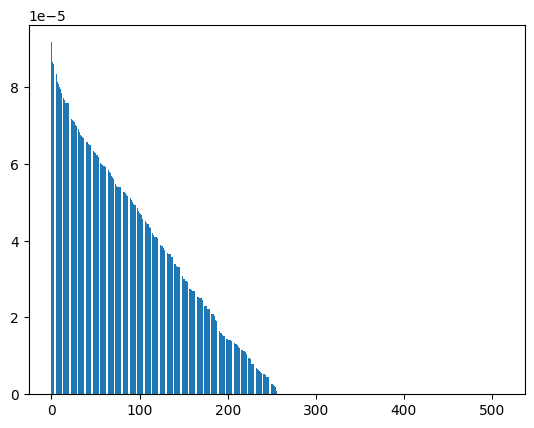

In [26]:
plt.bar(indices1.cpu(), sorted_tensor.cpu())  
plt.savefig(f'./camresult/cam/diff1_4_rad10/PN1stat512.png')
plt.show()

In [27]:
sorted_tensor, indices = torch.sort(pooled_gradients, descending=True)

In [28]:
custom_dataset = CustomNumpyDataset(filename=f'./rad5_80/datafilenewrad{10}.npz', transform=transform)


X=custom_dataset[20][0]
X1=X.cpu().detach().permute(1, 2, 0).numpy()
#X1=X1.float()
X1=np.array(X1, dtype=np.float64)
X1/=255
mask = (X1<0.98)
X1[mask]=0.2

#X1=X1*0.8
#plt.imshow(X1)
#plt.savefig(f'./camresult/cam/const1_4_rad10/origin{10*uu}.png')  # Save as PNG file
a2=X.unsqueeze(0).to(device)
a2=a2.float()
a2/= 255
mask = (a2<0.98)
a2[mask]=0.2
#argmin
scores,pool = model(a2)
pred=scores.argmax(dim=1)
loss=scores[0,pred[0]]
pool=pool.flatten()

model.zero_grad()
loss.backward()






pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
# weight the channels by corresponding gradients
cloned_activations=activations.clone()
detached_activations = cloned_activations.detach()
mask = pooled_gradients < 0
pooled_gradients[mask]=0
sorted_tensor, indices = torch.sort(pooled_gradients, descending=True)

Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])


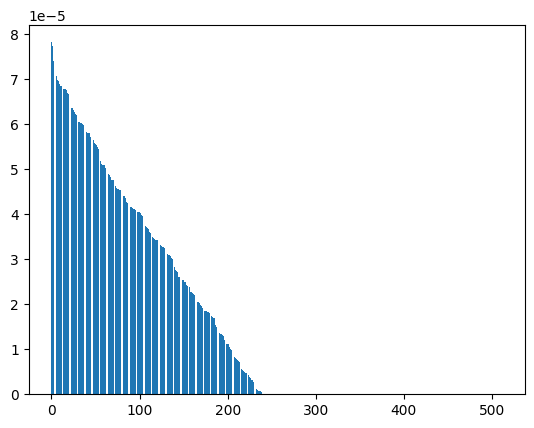

In [29]:
indices1 = torch.arange(len(sorted_tensor))  
plt.bar(indices1.cpu(), sorted_tensor.cpu())  
plt.savefig(f'./camresult/cam/diff1_4_rad10/PN4stat512.png')

plt.show()

In [51]:
len(gradients)

1

Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])
Forward hook running...
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running...
Gradients size: torch.Size([1, 512, 28, 28])


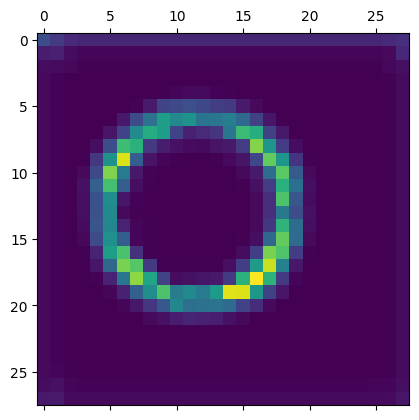

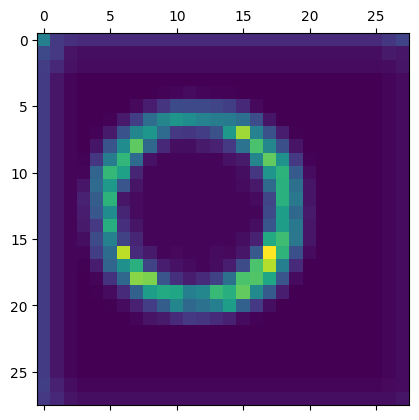

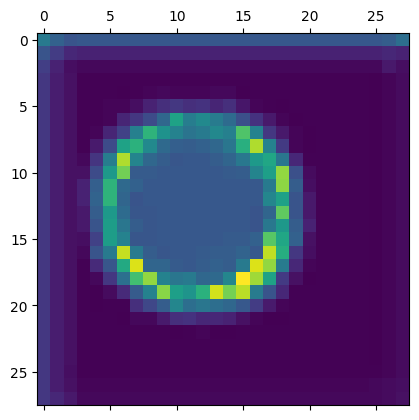

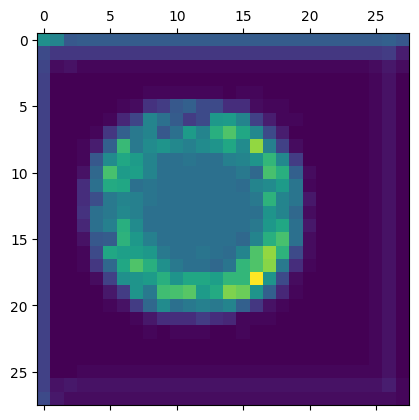

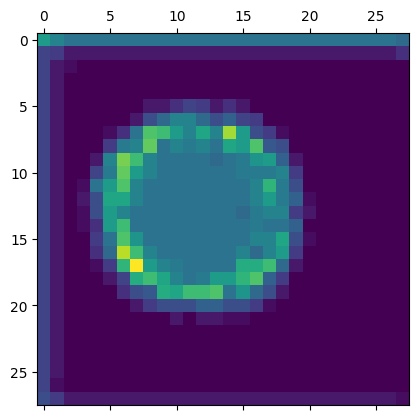

In [30]:
custom_dataset = CustomNumpyDataset(filename=f'./rad5_80/datafilenewrad{10}.npz', transform=transform)

for uu in range(0,5):
    

    X=custom_dataset[20][0]
    X1=X.cpu().detach().permute(1, 2, 0).numpy()
    #X1=X1.float()
    X1=np.array(X1, dtype=np.float64)
    X1/=255
    mask = (X1<0.98)
    X1[mask]=0.2

    #X1=X1*0.8
    #plt.imshow(X1)
    #plt.savefig(f'./camresult/cam/const1_4_rad10/origin{10*uu}.png')  # Save as PNG file
    a2=X.unsqueeze(0).to(device)
    a2=a2.float()
    a2/= 255
    mask = (a2<0.98)
    a2[mask]=0.2



    #argmin
    scores,pool = model(a2)
    pred=scores.argmin(dim=1)
    loss=scores[0,pred[0]]
    pool=pool.flatten()

    model.zero_grad()
    loss.backward()






    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    # weight the channels by corresponding gradients
    cloned_activations=activations.clone()
    detached_activations = cloned_activations.detach()
    mask = pooled_gradients < 0
    pooled_gradients[mask]=0
    sorted_tensor, indices = torch.sort(pooled_gradients, descending=True)
    top_3_elements = sorted_tensor[uu*50:uu*50+50]
    top_3_indices = indices[uu*50:uu*50+50]
    zerolike_tensor = torch.ones(1,512,28,28)
    zerolike_tensor=zerolike_tensor.to(device)
    empty_tensor = torch.zeros(28, 28) 
    for i in range(len(top_3_indices)):
        zerolike_tensor[:, top_3_indices[i], :, :]*= detached_activations[:, top_3_indices[i], :, :] * pooled_gradients[top_3_indices[i]]

    # average the channels of the activations
    heatmap = torch.mean(zerolike_tensor, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach().cpu())
    plt.savefig(f'./camresult/cam/diff1_4_rad10/myplottop{50*uu}min.png')  # Save as PNG file
